Output()

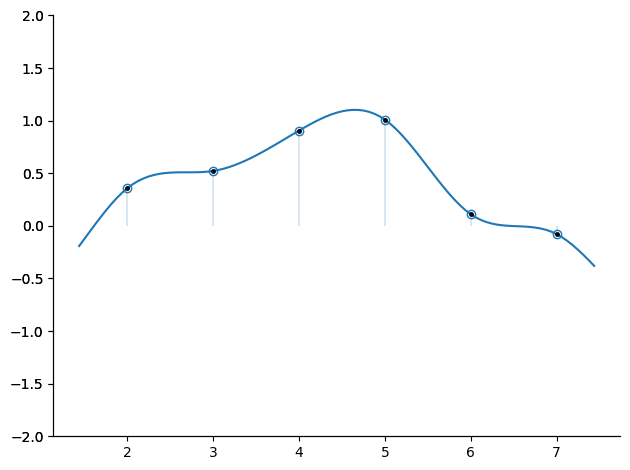

In [33]:
# Load the required libraries.
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import threading
import time
from IPython.display import clear_output
from IPython.display import display

import splinekit as sk # This library

# Setup
max_degree = 9 # Maximal spline degree
support = 6 # Length of the displayed spline
step_rate = 8 # Number of steps per unit domain
hertz = 12 # Refresh rate
pts = 2 * step_rate * support + 1 # Overall number of plot samples

# Inter-thread communication
thread = threading.local()
thread.out = widgets.Output() # Display
thread.resume_event = threading.Event() # Handshake
thread.forever = True # Handshake

# Initialize the plot and loop over updates
def start_animation(thread):
    t = 0 # Initial time
    s = sk.PeriodicSpline1D.from_spline_coeff(
        np.random.standard_normal(support + max_degree + 2), # Initial coefficients
        degree = 3 # Initial degree
    ) # Initial spline

    # Clean slate
    clear_output(wait = False)
    thread["out"].clear_output(wait = False)

    # Allow for pause, resume, and stop Buttons
    toggle_buttons = widgets.ToggleButtons(
        options = ["Pause", "Resume", "Stop"],
        index = 1
    )
    def on_toggle_changed(value):
        if "Pause" == toggle_buttons.value:
            thread["resume_event"].clear()
        elif "Resume" == toggle_buttons.value:
            thread["resume_event"].set()
        elif "Stop" == toggle_buttons.value:
            thread["resume_event"].set()
            thread["forever"] = False
            box.layout.display = "none"
    toggle_buttons.observe(on_toggle_changed, names = "value")

    # Allow for the selection of the degree
    int_range = widgets.IntSlider(min = 0, max = max_degree, value = s.degree)
    def on_value_change(change):
        nonlocal s
        s = s.projected(degree = change["new"])
    int_range.observe(on_value_change, names = "value")

    # Layout of the interactive panel
    box = widgets.VBox([
        widgets.HBox([toggle_buttons]),
        widgets.HBox([widgets.Label('degree'), int_range])
    ])
    display(box, thread["out"])

    # Layout of the plot
    plotrange = sk.interval.Closed((-2, 2))
    (fig, ax) = plt.subplots()
    hdisplay = display("", display_id = True)

    # Update of the plot
    def update_plot(ax, *, hdisplay):
        nonlocal t
        p = 2 * t - (s.degree + 1) * step_rate
        q = 2 * step_rate
        if 0 == p % q:
            # Innovation, create a new coefficient outside of the current plot
            s.spline_coeff[(p // q) % s.period] = np.random.standard_normal()
        subplot = plt.subplots()
        s.plot(
            subplot,
            plotpoints = pts,
            plotdomain = sk.interval.ClosedOpen((
                (0.5 + t) / step_rate,
                (0.5 + t) / step_rate + support
            )),
            plotrange = plotrange,
            periodbound_marker_fmt = "oC0",
            periodbound_stem_fmt = "-C0"
        )
        (fig, ax) = subplot
        plt.close()
        hdisplay.update(fig)
        t += 1

    # Never stop
    while thread["forever"]:
        thread["resume_event"].wait()
        update_plot(ax, hdisplay = hdisplay)
        time.sleep(1.0 / hertz)

# Start the animation and leave
t = threading.Thread(target = start_animation, args = [thread.__dict__])
t.start()
thread.resume_event.set()
